<a href="https://colab.research.google.com/github/miladramzy/SAMPE2023_Tutorial/blob/main/SAMPE2023_When_Data_efficient_Machine_Learning_Comes_to_the_Rescue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is provided as part of SAMPE 2023 tutorial session entitled "*When Data-efficient Machine Learning Comes to the Rescue: An AI-based Optimization Framework for Advanced Manufacturing.*" presented by Milad Ramezankhani and Dr. Abbas Milani. The tutorial's materials (including slides) can be found at: https://github.com/miladramzy/SAMPE2023_Tutorial

Step 0: Familiarise yourself with JAX

*   https://jax.readthedocs.io/en/latest/jax-101/index.html 
*   https://www.youtube.com/watch?v=WdTeDXsOSj4&ab_channel=TensorFlow 




Step 1: Import necessary libraries

In [47]:
import jax
import jax.numpy as np
from jax import grad, jit
import flax.linen as nn
import optax

import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Step 2: Load training data

In [5]:
# Source and target data directories (from tutorial's github page)
source_dir = 'https://raw.githubusercontent.com/miladramzy/SAMPE2023_Tutorial/main/data/AS4-8552_7mm.csv'
target_dir = 'https://raw.githubusercontent.com/miladramzy/SAMPE2023_Tutorial/main/data/AS4-8552_12mm.csv'

# Load data
s_data = pd.read_csv(source_dir) # Source data
t_data_full = pd.read_csv(target_dir) # Target data

In [ ]:
# Let's take a look at what's inside the datasets
print(s_data.head(20))
print(t_data_full.head(20))

In [ ]:
s_data.describe()
t_data_full.describe()

Step 3: Data preprocessing

*   Create a small subset of target data (limited data scenario)
*   Separate input and output variables
*   Standardize input features by removing the mean and scaling to unit variance
*   Split data into training and test sets



In [8]:
t_size = 100 # size of the target dataset (can be modified to investigate the performance of TL under different dataset sizes)
# Return random integers from low (inclusive) to high (exclusive)
t_index = onp.random.randint(low = 0, high = t_data_full.shape[0], size = t_size)
t_data = t_data_full.iloc[t_index, :]

t_data.describe()

,Top_HTC,Bottom_HTC,Ramp1,Hold1,Ramp2,Exotherm,Lag
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,54.100000,44.450000,2.990000,114.35000,2.950000,19.871034,33.609739
std,45.217655,39.733296,1.381662,6.98682,1.486471,10.659856,19.032357
min,10.000000,5.000000,1.000000,105.00000,1.000000,2.711669,3.659020
25%,10.000000,5.000000,2.000000,110.00000,2.000000,10.743458,17.897752
50%,10.000000,30.000000,3.000000,115.00000,3.000000,18.862970,29.309808
75%,100.000000,100.000000,4.000000,120.00000,4.000000,29.203073,47.834256
max,100.000000,100.000000,5.000000,125.00000,5.000000,37.293897,79.080105


In [9]:
# Transform data into numpy arrays
s_data_np = s_data.values
t_data_np = t_data.values

# Separate input and output variables
# Here we selected "exotherm" as the output of interest. One might choose "lag" as the output
# and repeat the experiment. Or, we can augment the output layer to two neurons and learn both outputs together.
s_in = s_data_np[:,:-2] # source input
s_out = s_data_np[:,-2] # source output (exotherm)
t_in = t_data_np[:,:-2] # target input
t_out = t_data_np[:,-2] # target output (exotherm)

In [10]:
# Define the source and target scalers and apply fit_transform to standardize the data
# https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d
# Standardize input features by removing the mean and scaling to unit variance
s_scaler = StandardScaler()
t_scaler = StandardScaler()
s_in_scaled = s_scaler.fit_transform(s_in)
t_in_scaled = t_scaler.fit_transform(t_in)

In [11]:
# Split source and target data into training and test sets
# Train and test
s_X_train, s_X_test, s_y_train, s_y_test = train_test_split(s_in_scaled, s_out, test_size=0.25, random_state=42)
# Train and validation
s_X_train, s_X_valid, s_y_train, s_y_valid = train_test_split(s_X_train, s_y_train, test_size=0.2, random_state=43)

# Train and test
t_X_train, t_X_test, t_y_train, t_y_test = train_test_split(t_in_scaled, t_out, test_size=0.25, random_state=44)
# Train and validation
t_X_train, t_X_valid, t_y_train, t_y_valid = train_test_split(t_X_train, t_y_train, test_size=0.2, random_state=45)

In [12]:
print('Source input training set shape:', s_X_train.shape)
print('Source output training set shape:', s_y_train.shape)
print('Source input test set shape:', s_X_test.shape)
print('Source output test set shape:', s_y_test.shape)
print('-----------------------------------------')
print('Target input training set shape:', t_X_train.shape)
print('Target output training set shape:', t_y_train.shape)
print('Target input test set shape:', t_X_test.shape)
print('Target output test set shape:', t_y_test.shape)

Source input training set shape: (524, 5)
Source output training set shape: (524,)
Source input test set shape: (219, 5)
Source output test set shape: (219,)
-----------------------------------------
Target input training set shape: (60, 5)
Target output training set shape: (60,)
Target input test set shape: (25, 5)
Target output test set shape: (25,)


Step 4: Define a neural network to train source network


*   We use **[flax](https://flax.readthedocs.io/en/latest/)** library to create neural networks here. Flax delivers an end-to-end and flexible user experience for researchers who use JAX with neural networks.
*   Define loss function. Here, we used mean squared error to calculate the loss.
*   Define [step function](https://optax.readthedocs.io/en/latest/optax-101.html) that calculates gradients and update parameters accordingly.
*   Define optimzer for training the network. Here ADAM optimizer is selected.







In [80]:
# The defined network has 2 hidden layers, each with 32 neurons, and an output layer
# with 1 neuron. RELU activation function is chosen for neurons' nonlinearities.

class Net(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=32, name='layer1')(x)
        x = nn.relu(x)
        x = nn.Dense(features=32, name='layer2')(x)
        x = nn.relu(x)
        x = nn.Dense(features=1, name='output')(x)
        return x

# Initializing the SOURCE network
rng = jax.random.PRNGKey(0)
x_init = jax.random.normal(rng, (20, 5)) # generate a random input for initializing the network

model = Net(features=5) # specify the dimension of the input dataset (here, 5)
params = model.init(rng, x_init) # .init gives the initial parameters
out = model.apply(params, x_init) # we can make a prediction using .apply

In [ ]:
print(params)

In [ ]:
print(out)

In [81]:
# Loss function calculating mean squared error
@jit
def loss(params, x, y):

    pred = model.apply(params, x)
    loss_value = np.mean((pred.flatten() - y.flatten())**2)
    
    return loss_value

# Optimization step function
@jit
def step_optax(params, opt_state, x, y):
    grads = grad(loss, argnums=0)(params, x, y) # Calculate gradients 
    updates, opt_state = optimizer.update(grads, opt_state, params) # For the Adam optimizer, opt_state contains the momentum values.
    params = optax.apply_updates(params, updates) # Updated parameters

    return params, opt_state

# Adam optimizer
lr = 5e-4 
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(params)

In [95]:
# Utils
# A function that plots the model's training history
def plot_training_history(epoch, loss_train, loss_valid):
  
  fig, ax = plt.subplots(figsize=(6,4), layout="tight")
  plt.plot(epoch, loss_train, label = 'Training loss')
  plt.plot(epoch, loss_valid, label = 'Validation loss')
  plt.xlabel('epochs')
  plt.ylabel('loss (MSE)')
  plt.yscale('log')
  plt.legend()
  plt.show()

# A function that calculates mse, rmse and r^2
def model_eval(observation, prediction):

  s_mse = mean_squared_error(observation, prediction, squared=True)
  s_rmse = mean_squared_error(observation, prediction, squared=False)
  s_r2 = r2_score(observation, prediction)

  return s_mse, s_rmse, s_r2

Step 5: Training the source network

In [82]:
loss_train_log = []
loss_valid_log = []
epoch_log = []
loss_val_ref = 1e5 # needed for early stopping

nIter = 60000 # number of epochs
itercount = itertools.count()

pbar = trange(nIter)
# Main training loop
for it in pbar:
    current_count = next(itercount)
    params, opt_state = step_optax(params, opt_state, s_X_train, s_y_train)

    if it % 50 == 0 and it > 0:
        loss_train = loss(params, s_X_train, s_y_train)
        loss_valid = loss(params, s_X_valid, s_y_valid)

        # log
        loss_train_log.append(loss_train)
        loss_valid_log.append(loss_valid)
        epoch_log.append(current_count)
        
        # early stopping
        improvement = (loss_val_ref - loss_valid)
        if improvement < 0.00005: # Minimum change in the monitored quantity to qualify as an improvement
          break
        else:
          loss_val_ref = loss_valid

        pbar.set_postfix({'Loss_train': loss_train, 'loss_valid': loss_valid})

 16%|█▋        | 9900/60000 [00:05<00:25, 1960.86it/s, Loss_train=0.011201718, loss_valid=0.08249699]


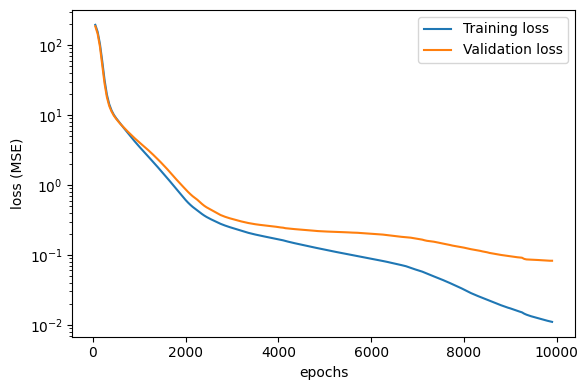

Mean squared error: 0.06867150367296221
Root mean squared error: 0.2620524826689536
R-squared: 0.9985309698182643


In [98]:
# Visualize training/validation losses
plot_training_history(epoch_log, loss_train_log, loss_valid_log)

# Model evaluation
s_y_pred_test = model.apply(params, s_X_test) # predictions
s_mse, s_rmse, s_r2 = model_eval(s_y_test, s_y_pred_test)

print('Mean squared error:', s_mse)
print('Root mean squared error:', s_rmse)
print('R-squared:', s_r2)

**Overfitting and how to avoid it**: https://aws.amazon.com/what-is/overfitting/

**Early stopping**

Early stopping pauses the training phase before the machine learning model learns the noise in the data. However, getting the timing right is important; else the model will still not give accurate results.

**Pruning**

You might identify several features or parameters that impact the final prediction when you build a model. Feature selection—or pruning—identifies the most important features within the training set and eliminates irrelevant ones.

**Data augmentation**

Data augmentation is a machine learning technique that changes the sample data slightly every time the model processes it. You can do this by changing the input data in small ways.  

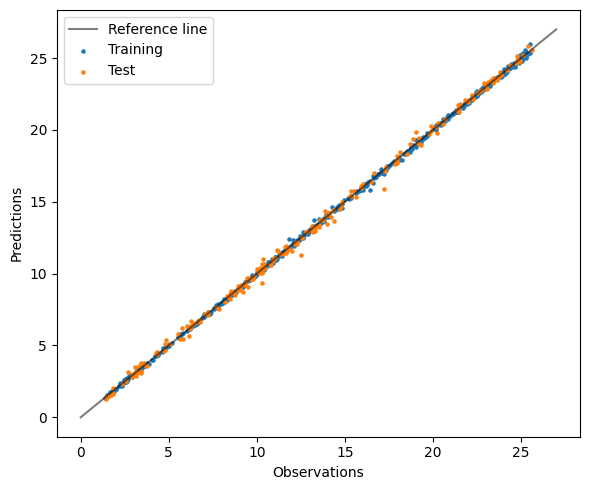

In [86]:
# Model performance visualization (pareto plot)
fig, ax = plt.subplots(figsize=(6,5), layout="tight")
y_pred_train = model.apply(params, s_X_train)
y_pred_test = model.apply(params, s_X_test)
#y_pred_test_t = model.apply(params, t_X_test)
plt.plot([0,27], [0,27], c = 'black', alpha = 0.5, label = 'Reference line')
plt.scatter(s_y_train, y_pred_train, s = 5, label = 'Training')
plt.scatter(s_y_test, y_pred_test, s = 5, label = 'Test')
#plt.scatter(t_y_test, y_pred_test_t, s = 5, label = 'Target prediction using source network')
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.legend()

In [53]:
# MSE loss when using source model to predict target observations
loss_test = loss(params, t_X_test, t_y_test)
print(loss_test)

53.822197


Step 6: **Transfer learning**: Training the target network

*   Knowledge transfer: using weights from the source network to initialize the target network
*   Fine-tuning: updating the weights via a small number of gradient steps and limited available data to learn the target mapping function
*   Compare the performance of transfer learning with no-TL approach.





In [90]:
# Initializing the TARGET network
# No need to redefine a target network as both source and target
# networks have the same architecture.
t_params = params

> When training the target network, be careful about [**catastrophic forgetting**](https://en.wikipedia.org/wiki/Catastrophic_interference#:~:text=Catastrophic%20interference%2C%20also%20known%20as,information%20upon%20learning%20new%20information.)

In [91]:
t_loss_train_log = []
t_loss_valid_log = []
t_epoch_log = []
loss_val_ref = 1e5 # needed for early stopping

# Adam optimizer
lr = 1e-5 # For training the target network, a smaller learning rate is chosen to avoid catasterophic forgetting
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(t_params)
nIter = 60000
itercount = itertools.count()

pbar = trange(nIter)
# Main training loop
for it in pbar:
    current_count = next(itercount)
    t_params, opt_state = step_optax(t_params, opt_state, t_X_train, t_y_train)

    if it % 50 == 0 and it > 0:
        loss_train = loss(t_params, t_X_train, t_y_train)
        loss_valid = loss(t_params, t_X_valid, t_y_valid)

        # log
        t_loss_train_log.append(loss_train)
        t_loss_valid_log.append(loss_valid)
        t_epoch_log.append(current_count)
        
        # early stopping
        improvement = (loss_val_ref - loss_valid)
        if improvement < 0.00005: # Minimum change in the monitored quantity to qualify as an improvement
          break
        else:
          loss_val_ref = loss_valid

        pbar.set_postfix({'Loss_train': loss_train, 'loss_valid': loss_valid})

 43%|████▎     | 25700/60000 [00:06<00:09, 3731.53it/s, Loss_train=7.005365e-07, loss_valid=0.6833825]


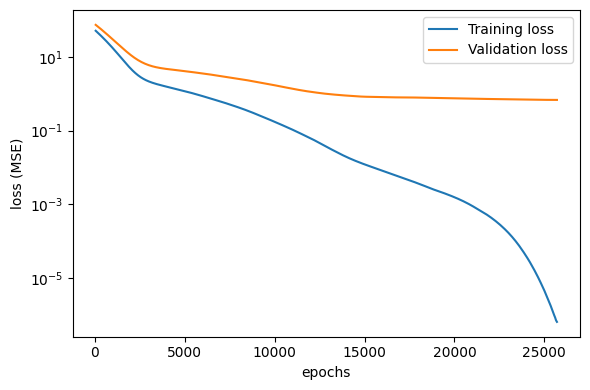

Mean squared error: 1.3429848561885565
Root mean squared error: 1.1588722346266462
R-squared: 0.987642827463372


In [99]:
# Visualize training/validation losses
plot_training_history(t_epoch_log, t_loss_train_log, t_loss_valid_log)

# Model evaluation
t_y_pred_test = model.apply(t_params, t_X_test) # predictions
s_mse, s_rmse, s_r2 = model_eval(t_y_test, t_y_pred_test)

print('Mean squared error:', s_mse)
print('Root mean squared error:', s_rmse)
print('R-squared:', s_r2)

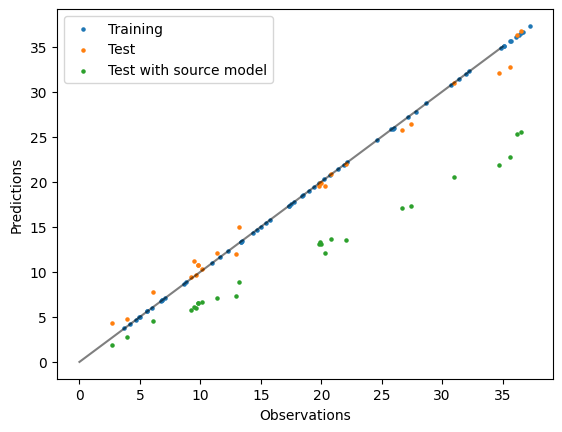

In [103]:
# Model performance visualization (pareto plot)
y_pred_train_t = model.apply(t_params, t_X_train)
y_pred_test_t = model.apply(t_params, t_X_test)
y_pred_test_ts = model.apply(params, t_X_test)
plt.plot([0,35], [0,35], c = 'black', alpha = 0.5)
plt.scatter(t_y_train, y_pred_train_t, s = 5, label = 'Training')
plt.scatter(t_y_test, y_pred_test_t, s = 5, label = 'Test')
plt.scatter(t_y_test, y_pred_test_ts, s = 5, label = 'Test with source model')
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.legend()

In [114]:
notl_params = model.init(rng, x_init) # Random init for learning the target task from scratch

In [115]:
nt_loss_train_log = []
nt_loss_valid_log = []
nt_epoch_log = []
loss_val_ref = 1e5 # needed for early stopping

# Adam optimizer
lr = 5e-4
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(notl_params)

nIter = 100000
itercount = itertools.count()

pbar = trange(nIter)
# Main training loop
for it in pbar:
    current_count = next(itercount)
    notl_params, opt_state = step_optax(notl_params, opt_state, t_X_train, t_y_train)

    if it % 50 == 0 and it > 0:
        loss_train = loss(notl_params, t_X_train, t_y_train)
        loss_valid = loss(notl_params, t_X_valid, t_y_valid)

        # log
        nt_loss_train_log.append(loss_train)
        nt_loss_valid_log.append(loss_valid)
        nt_epoch_log.append(current_count)
        
        # early stopping
        improvement = (loss_val_ref - loss_valid)
        if improvement < 0.00005: # Minimum change in the monitored quantity to qualify as an improvement
          break
        else:
          loss_val_ref = loss_valid
        
        pbar.set_postfix({'Loss_train': loss_train, 'loss_valid': loss_valid})

 66%|██████▌   | 65500/100000 [00:15<00:08, 4210.19it/s, Loss_train=7.180871e-07, loss_valid=2.0429873]


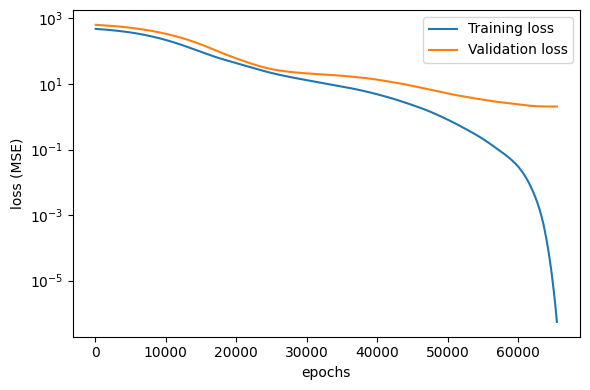

Mean squared error: 8.05707093957794
Root mean squared error: 2.8384980076755277
R-squared: 0.9258646772661465


In [120]:
# Visualize training/validation losses
plot_training_history(nt_epoch_log, nt_loss_train_log, nt_loss_valid_log)

# Model evaluation
no_tl_y_pred_test = model.apply(notl_params, t_X_test) # predictions
s_mse, s_rmse, s_r2 = model_eval(t_y_test, no_tl_y_pred_test)

print('Mean squared error:', s_mse)
print('Root mean squared error:', s_rmse)
print('R-squared:', s_r2)

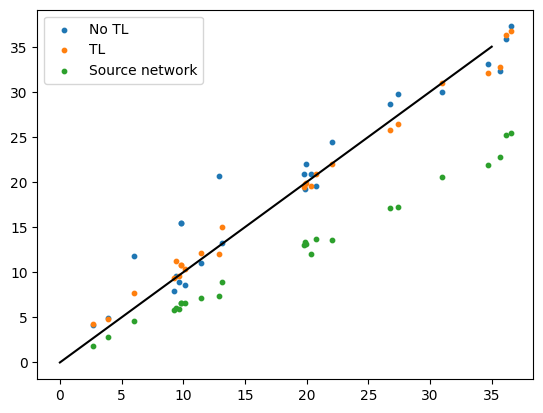

In [118]:
notl_y_pred_test = model.apply(notl_params, t_X_test)
plt.plot([0,35], [0,35], c = 'black')

plt.scatter(t_y_test, notl_y_pred_test, s = 10, label = 'No TL')
plt.scatter(t_y_test, y_pred_test_t, s = 10, label = 'TL')
plt.scatter(t_y_test, y_pred_test_ts, s = 10, label = 'Source network')
plt.legend()

End of tutorial